In [1]:
from kneed import DataGenerator, KneeLocator
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import scipy.io
from scipy.signal import find_peaks
import json
import numpy as np
import pickle
import resync as rs

fs = 160

In [10]:
path = '/Volumes/data2/eTheremin/ALTAI/ALTAI_20240722_SESSION_04/'

In [11]:
def clean_positions(positions):
    """
    Fonction de nettoyage des positions enregistrées au cours de l'expérience. Pour rappel, une valeur de -1, indique que le sujet n'a pas été détecté par le réseau de neurones.
    :param positions: 
    :return: 
    """
    y = np.where(positions == -1)[0]
    diff_y = np.diff(y)
    diff_y = np.vstack((np.arange(1, len(diff_y) + 1), diff_y)).T
    k = 0
    begin = 0
    for i, elt in diff_y:
        if elt != 1:
            positions[y[i - 1]] = positions[y[i - 1] + 1]
            positions[y[i]] = positions[y[i] - 1]
            if k != 0:
                end = y[i - 1]
                filler = np.full(shape=k, fill_value=positions[begin - 1])
                positions[begin:end] = filler
                k = 0
        else:
            if k == 0:
                begin = y[i - 1]
            k += 1
    remainder = np.where(positions == -1)[0]
    if len(remainder) != 0 and k != 0:
        pass

    return positions

In [12]:
positions = rs.load_positions_file(path)
positions = [file for file in positions if file != ""]


In [14]:
print(positions)
p = positions[0]
# Attention, positions en deux dimensions !
p = np.fromfile(p, dtype=np.int32)
x_p = p[np.arange(0, len(p), step=2)]
y_p = p[np.arange(1, len(p), step=2)]
#mapping = rs.Mapping(1920, 33, 2000., 7)
clean_x_p = clean_positions(x_p)  # Pour retirer les -1.

['/Volumes/data2/eTheremin/ALTAI/ALTAI_20240722_SESSION_04/positions/positions_tracking_00_ALTAI_SESSION_04_20240722.bin']


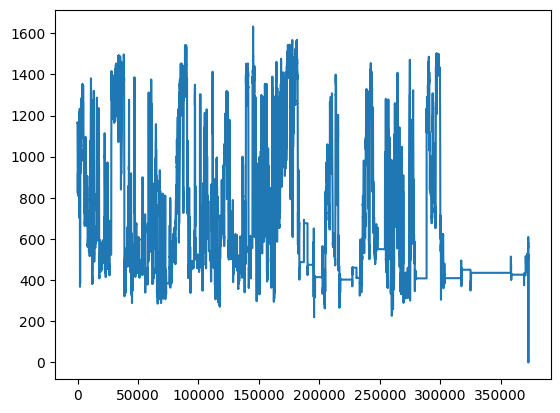

In [15]:
plt.plot(clean_x_p)

In [16]:
len(clean_x_p)/fs


2331.075

In [17]:
tt_path = path+'headstage_0/tt.pkl'
with open(tt_path, 'rb') as file:
    tt = pickle.load(file)

tt_positions_path = path+'headstage_0/tt_positions.pkl'
with open(tt_positions_path, 'rb') as file:
    tt_positions = pickle.load(file)


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/data2/eTheremin/ALTAI/ALTAI_20240722_SESSION_04/headstage_0/tt_positions.pkl'

In [11]:
print(len(tt_positions['triggers']),len(tt['triggers']))

NameError: name 'tt_positions' is not defined

In [18]:
tone_vec = mapping.convert_to_frequency(clean_x_p)
d = np.diff(tone_vec)
idx = np.where(d != 0)[0] + 1
trigs= idx/fs
switch = tone_vec[idx]

In [19]:
switch = tone_vec[idx]

print(len(switch))
print(len(tt['tones']))
print(len(tt['triggers']))
print(len(trigs))

5750
5749
5721
5750


In [20]:
dig = np.load(path +'dig_in.npy')

In [21]:
print(len(dig[0])/30000)
print(len(clean_x_p)/fs)

2329.966933333333
2331.075


In [22]:
trig_camera = dig[0]
trig_pos = clean_x_p

In [24]:

# Étape 1: Identifier les indices des triggers dans trig_camera
sampling_rate_camera = 30000  # 30 kHz
time_per_sample_camera = 1 / sampling_rate_camera  # Temps par échantillon
trigger_times_camera = np.where(trig_camera)[0] * time_per_sample_camera  # Convertir les indices en temps

In [26]:
# Étape 2: Identifier les temps pour trig_pos
sampling_rate_pos = 160  # 160 Hz
time_per_sample_pos = 1 / sampling_rate_pos 
trigger_times_pos = trig_pos  



In [28]:
len(trigger_times_camera)

16006278

In [30]:

# Étape 3: Correspondre les temps des triggers
corresponding_triggers = []

# On vérifie pour chaque trigger de trig_camera s'il correspond à un trigger dans trig_pos
for camera_time in trigger_times_camera[0:1000]:
    # Vérifier s'il existe un trigger dans trig_pos à un temps pas trop éloigné
    for pos_time in trigger_times_pos:
        if np.isclose(camera_time, pos_time, atol=1e-5):  # atol c'est la tolérance pour comparer
            corresponding_triggers.append(camera_time)

# Résultat
print("Corresponding Triggers in trig_pos:", corresponding_triggers)


Corresponding Triggers in trig_pos: []


In [50]:
np.sum(trig_camera)

np.int64(16006278)

In [14]:
analog_trigs = np.array(tt['triggers'])/30000
pos_trigs = trigs

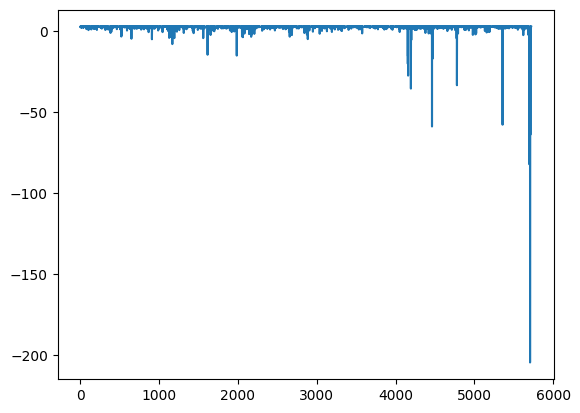

In [15]:
delta_trigs = []
for i in range(len(analog_trigs)):
    delta_trigs.append((analog_trigs[i]-pos_trigs[i]))
plt.plot(delta_trigs)

In [16]:
delta_average = np.nanmean(delta_trigs)
pos_trigs_recalé = pos_trigs + delta_average

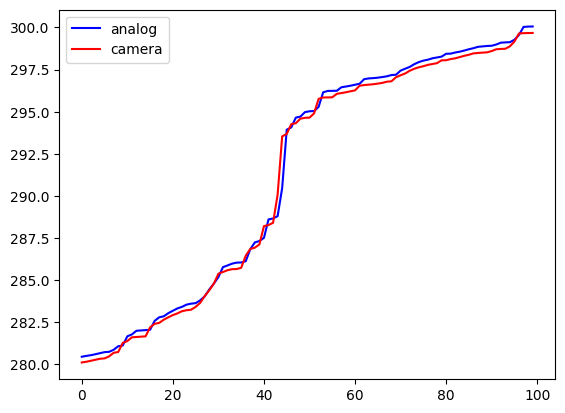

In [17]:
plt.plot(analog_trigs[1000:1100], c = 'b', label = 'analog')
plt.plot(pos_trigs_recalé[1000:1100], c='red', label = 'camera')
plt.legend()

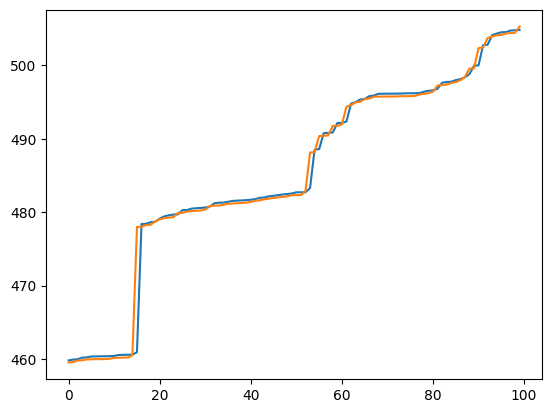

In [18]:
plt.plot(analog_trigs[1600:1700])
plt.plot(pos_trigs_recalé[1600:1700])

In [ ]:
new_tt = {
        'tones': switch,
        'triggers': pos_trigs_recalé*30000,
        'block': np.zeros(len(trigs)), 
        'condition' : np.zeros(len(trigs)),
        'mock_triggers' : np.zeros(len(trigs)),
        'mock_tones' : np.zeros(len(trigs))
    }

In [ ]:
with open(path+'headstage_0/tt_positions.pkl', 'wb') as file:
    pickle.dump(new_tt, file)

OSError: [Errno 28] No space left on device

In [ ]:
dig_in = np.load(path + 'headstage_0/dig_in.npy')

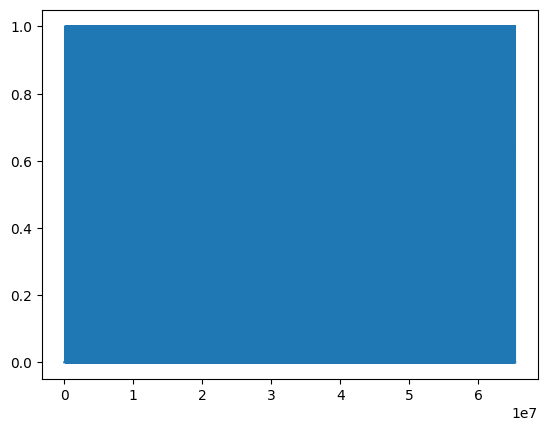

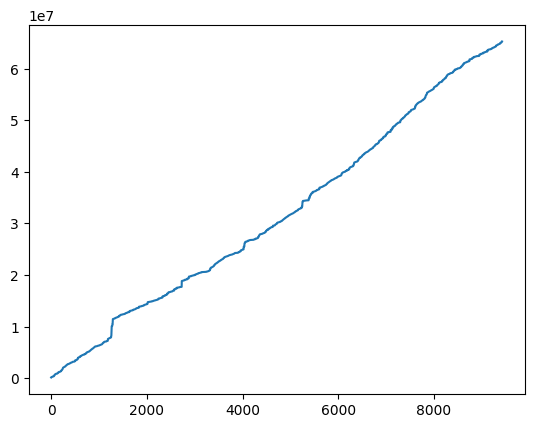

In [ ]:
plt.plot(tt['triggers'])

In [ ]:
new_tt = {
        'tones': switch,
        'triggers': trigs*30000,
        'block': np.zeros(len(trigs)), 
        'condition' : np.zeros(len(trigs)),
        'mock_triggers' : np.zeros(len(trigs)),
        'mock_tones' : np.zeros(len(trigs))
    }

In [ ]:
new_tt

{'tones': array([1727., 2000., 2317., ...,  715.,  828.,  715.]),
 'triggers': array([3.74250000e+03, 2.69925000e+04, 5.98050000e+04, ...,
        6.50868675e+07, 6.50870550e+07, 6.50889300e+07]),
 'block': array([0., 0., 0., ..., 0., 0., 0.]),
 'condition': array([0., 0., 0., ..., 0., 0., 0.]),
 'mock_triggers': array([0., 0., 0., ..., 0., 0., 0.]),
 'mock_tones': array([0., 0., 0., ..., 0., 0., 0.])}

In [ ]:
with open(path+'headstage_0/tt_positions.pkl', 'wb') as file:
        pickle.dump(new_tt, file)


In [ ]:
tt_path = path+'headstage_0/tt.pkl'
with open(tt_path, 'rb') as file:
    tt = pickle.load(file)

In [ ]:
tt['triggers']

[152577,
 156097,
 179337,
 212137,
 222657,
 225457,
 229257,
 241777,
 243657,
 244977,
 247057,
 249457,
 253257,
 256617,
 261817,
 262017,
 262257,
 280257,
 285817,
 287497,
 289257,
 290137,
 290937,
 291657,
 292777,
 294097,
 295257,
 295977,
 296737,
 297297,
 298057,
 298777,
 300097,
 323577,
 327297,
 346617,
 360817,
 361257,
 361777,
 362737,
 363297,
 365937,
 366097,
 366457,
 366657,
 368337,
 368577,
 370777,
 371137,
 377937,
 378097,
 379977,
 380137,
 381457,
 385777,
 386937,
 394977,
 450297,
 451977,
 454017,
 454417,
 457017,
 477297,
 528657,
 535417,
 537297,
 537817,
 538257,
 538417,
 557137,
 560577,
 651297,
 656137,
 658977,
 666657,
 666817,
 667417,
 684097,
 690297,
 710337,
 719137,
 721617,
 724017,
 773737,
 775417,
 775617,
 781617,
 788337,
 804817,
 811617,
 820617,
 823617,
 834657,
 834817,
 840457,
 847256,
 856256,
 856776,
 856976,
 858296,
 860576,
 861696,
 864096,
 865976,
 867096,
 869496,
 869936,
 870656,
 871776,
 872736,
 873096,
 

In [ ]:
print(len(tt['tones']))
print(len(switch))

9504
9503


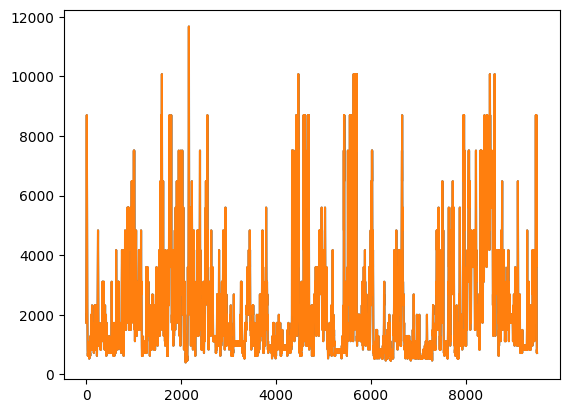

In [ ]:
plt.plot(tt['tones'])
plt.plot(switch)

In [ ]:

def detect_frequency_switch(vec, mapping, mock_tones):
    """
    Fonction qui a pour objectif de détecter les changements de fréquences.
    :param mapping:
    :param vec:
    :param mock_tones:
    :return:
    """
    # print(np.unique(vec))
    tone_vec = mapping.convert_to_frequency(vec)
    d = np.diff(tone_vec)
    idx = np.where(d != 0)[0] + 1
    switch = tone_vec[idx]
    return switch

In [ ]:
trigg=s

NameError: name 's' is not defined

In [ ]:
tones_from_positions = rs.detect_frequency_switch(positions, mapping, None)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices